Scikit-learn GradientBoostingRegressor() model on final_df.csv.

Time Series cross-validation: 24h delay for weather, 1 month gap between train and test sets.

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Dataframe is loaded, datetime column is dropped in order to run model.

In [125]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
df['255439'] = df['object_id']==255439
df['255440'] = df['object_id']==255440
df['255441'] = df['object_id']==255441
df['255442'] = df['object_id']==255442
df['255443'] = df['object_id']==255443
df['255444'] = df['object_id']==255444
df['255445'] = df['object_id']==255445
df['280324'] = df['object_id']==280324
df['303910'] = df['object_id']==303910
df = df.sort_values(by=['result_timestamp','object_id'])


In [126]:
df['key'] = df['object_id'].astype('str') + df['result_timestamp']
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'],format='%Y-%m-%d %H:%M:%S')


In [127]:
df_noisedelay = df[['object_id','result_timestamp','laeq']]
df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
df_noisedelay['key'] = df_noisedelay['object_id'].astype('str') + df_noisedelay['result_timestamp'].astype('str')
df_noisedelay = df_noisedelay.drop(['laeq','object_id','result_timestamp'], axis=1)

df_weatherdelay = df[['object_id','result_timestamp','LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                   'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']]
df_weatherdelay['result_timestamp'] = df_weatherdelay['result_timestamp']+pd.DateOffset(days=1)
df_weatherdelay['key'] = df_weatherdelay['object_id'].astype('str') + df_weatherdelay['result_timestamp'].astype('str')
df_weatherdelay = df_weatherdelay.drop(['object_id','result_timestamp'], axis=1)
df = df.drop(['LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0'],axis=1)


C:\Users\Arthur\AppData\Local\Temp\ipykernel_7124\727566501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_7124\727566501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
C:\Users\Arthur\AppData\Local\Temp\ipykernel_7124\727566501.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [128]:
df = pd.merge(df,df_noisedelay, on='key',validate='1:1')
df= pd.merge(df,df_weatherdelay, on='key',validate='1:1')
df_nd = df.drop(['key','object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)

In [129]:
df_nd.isna().sum()


laeq             0
hour             0
weekday          0
month            0
weekend          0
holiday          0
exam_period      0
255439           0
255440           0
255441           0
255442           0
255443           0
255444           0
255445           0
280324           0
303910           0
laeq_delayed     0
LC_HUMIDITY     43
LC_DWPTEMP      43
LC_n            43
LC_RAD          43
LC_RAININ       43
LC_DAILYRAIN    43
LC_WINDDIR      43
LC_WINDSPEED    43
LC_RAD60         4
LC_TEMP_QCL0    43
dtype: int64

In [130]:
df_nd = df_nd[df_nd.isna()['LC_HUMIDITY']==False]
df_nd.isna().sum()

laeq            0
hour            0
weekday         0
month           0
weekend         0
holiday         0
exam_period     0
255439          0
255440          0
255441          0
255442          0
255443          0
255444          0
255445          0
280324          0
303910          0
laeq_delayed    0
LC_HUMIDITY     0
LC_DWPTEMP      0
LC_n            0
LC_RAD          0
LC_RAININ       0
LC_DAILYRAIN    0
LC_WINDDIR      0
LC_WINDSPEED    0
LC_RAD60        0
LC_TEMP_QCL0    0
dtype: int64

In [131]:
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Monday', value=0)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Tuesday', value=1)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Wednesday', value=2)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Thursday', value=3)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Friday', value=4)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Saturday', value=5)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Sunday', value=6)

The target dataset (y) and predictor dataset (X) are created. For y, noise is converted to relative noise (proportion of max value)

In [132]:
y = df_nd["laeq"]
X = df_nd.drop(["laeq","laeq_delayed"], axis="columns")

In [133]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=38880,
    max_train_size=66000,
    test_size=30000,
)

In [134]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
4,0,6,1,True,True,False,False,False,True,False,...,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28
5,0,6,1,True,True,False,False,False,False,True,...,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28
6,0,6,1,True,True,False,False,False,False,False,...,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28
7,0,6,1,True,True,False,False,False,False,False,...,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28
8,0,6,1,True,True,False,False,False,True,False,...,90.0,11.72,37.0,0.0,0.0,0.0,45.0,0.02,0.0,13.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,2,2,2,False,False,False,False,False,False,False,...,93.0,5.39,38.0,0.0,0.0,0.0,-65.0,0.00,0.0,6.39
25836,3,2,2,False,False,False,False,False,True,False,...,93.0,5.39,37.0,0.0,0.0,0.0,0.0,0.00,0.0,6.39
25837,3,2,2,False,False,False,False,False,False,True,...,93.0,5.39,37.0,0.0,0.0,0.0,0.0,0.00,0.0,6.39
25838,3,2,2,False,False,False,False,False,False,False,...,93.0,5.39,37.0,0.0,0.0,0.0,0.0,0.00,0.0,6.39


In [135]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
199861,4,3,8,False,True,False,False,False,True,False,...,70.0,16.22,31.0,0.0,0.0,0.0,-46.0,0.01,0.0,21.89
199862,4,3,8,False,True,False,False,False,False,True,...,70.0,16.22,31.0,0.0,0.0,0.0,-46.0,0.01,0.0,21.89
199863,4,3,8,False,True,False,False,False,False,False,...,70.0,16.22,31.0,0.0,0.0,0.0,-46.0,0.01,0.0,21.89
199864,4,3,8,False,True,False,False,False,False,False,...,70.0,16.22,31.0,0.0,0.0,0.0,-46.0,0.01,0.0,21.89
199865,4,3,8,False,True,False,False,False,False,False,...,70.0,16.22,31.0,0.0,0.0,0.0,-46.0,0.01,0.0,21.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265874,12,5,10,True,False,False,False,False,False,False,...,59.0,14.76,38.0,109.0,0.0,0.0,-109.0,0.04,124.0,23.11
265875,12,5,10,True,False,False,False,False,True,False,...,60.0,14.94,37.0,100.0,0.0,0.0,-113.0,0.12,124.0,23.01
265876,12,5,10,True,False,False,False,False,False,True,...,60.0,14.94,37.0,100.0,0.0,0.0,-113.0,0.12,124.0,23.01
265877,12,5,10,True,False,False,False,False,False,False,...,60.0,14.94,37.0,100.0,0.0,0.0,-113.0,0.12,124.0,23.01


In [136]:
# grid search for hyperparameter tuning
param_grid = {
    'learning_rate': (0.10,0.11,0.12),
    'max_leaf_nodes': (8,9,10,11)}
model = GradientBoostingRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=4320, max_train_size=66000, n_splits=5, test_size=60000),
             estimator=GradientBoostingRegressor(), n_jobs=2,
             param_grid={'learning_rate': (0.1, 0.11, 0.12),
                         'max_leaf_nodes': (8, 9, 10, 11)})

In [137]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.73


In [138]:
model_grid_search.predict(X.iloc[0:5])

array([48.87871985, 41.19980494, 41.19980494, 38.90721974, 48.87871985])

In [139]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.12, 'max_leaf_nodes': 10}


In [140]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,12.360484,3.950752,0.106162,0.023862,0.12,10,"{'learning_rate': 0.12, 'max_leaf_nodes': 10}",0.091609,0.658373,0.632126,0.437609,0.630894,0.490122,0.214411,1
9,11.408099,3.389941,0.092787,0.003161,0.12,9,"{'learning_rate': 0.12, 'max_leaf_nodes': 9}",0.088019,0.658370,0.632126,0.438904,0.630621,0.489608,0.215648,2
6,11.511854,3.465893,0.093964,0.008202,0.11,10,"{'learning_rate': 0.11, 'max_leaf_nodes': 10}",0.095182,0.659711,0.629378,0.453089,0.607383,0.488949,0.209402,3
5,11.460198,3.387340,0.106531,0.011545,0.11,9,"{'learning_rate': 0.11, 'max_leaf_nodes': 9}",0.095247,0.659711,0.629811,0.451991,0.607477,0.488848,0.209484,4
7,11.605944,3.499254,0.109281,0.013381,0.11,11,"{'learning_rate': 0.11, 'max_leaf_nodes': 11}",0.095310,0.659711,0.629378,0.453140,0.606591,0.488826,0.209263,5


In [141]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [142]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
10,0.12,10,0.490122,0.214411,1
9,0.12,9,0.489608,0.215648,2
6,0.11,10,0.488949,0.209402,3
5,0.11,9,0.488848,0.209484,4
7,0.11,11,0.488826,0.209263,5
4,0.11,8,0.488729,0.209447,6
0,0.1,8,0.488197,0.214755,7
3,0.1,11,0.488188,0.214550,8
8,0.12,8,0.488183,0.214431,9
2,0.1,10,0.488080,0.214724,10


In [143]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_learning_rate"],
    columns=["param_max_leaf_nodes"])

pivoted_cv_results

param_max_leaf_nodes,8,9,10,11
param_learning_rate,,,,
0.10,0.488197,0.488054,0.488080,0.488188
0.11,0.488729,0.488848,0.488949,0.488826
0.12,0.488183,0.489608,0.490122,0.486424


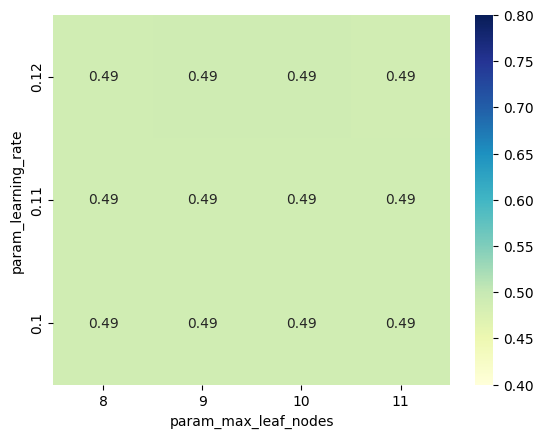

In [144]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

Mean Absolute Error:     3.180 +/- 0.423
Root Mean Squared Error: 4.430 +/- 0.738


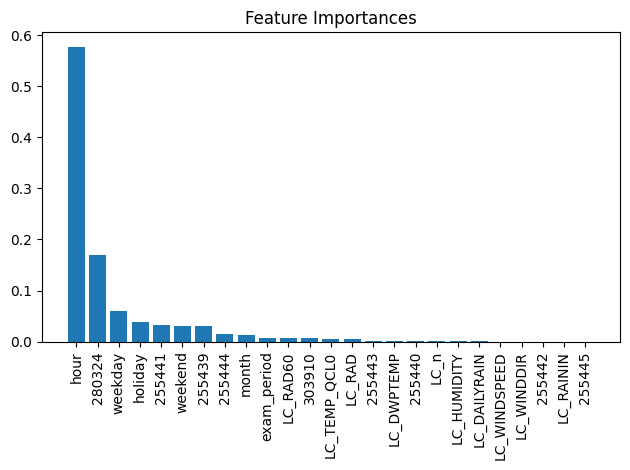

In [145]:
#run gradient boosting model and plot feature importances
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

    # Fit the model on the data
    model.fit(X, y)

    # Retrieve feature importances
    feature_importances = model.named_steps['gradientboostingregressor'].feature_importances_
    feature_names = X.columns

    # Sort feature importances in descending order
    indices = np.argsort(feature_importances)[::-1]

    # Plot feature importances
    plt.figure()
    plt.title('Feature Importances')
    plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
    plt.xticks(range(X.shape[1]), feature_names[indices], rotation='vertical')
    plt.tight_layout()
    plt.show()

gbrt_pipeline = make_pipeline(GradientBoostingRegressor(max_leaf_nodes=10, learning_rate=0.11))
evaluate(gbrt_pipeline, X, y, cv=ts_cv)


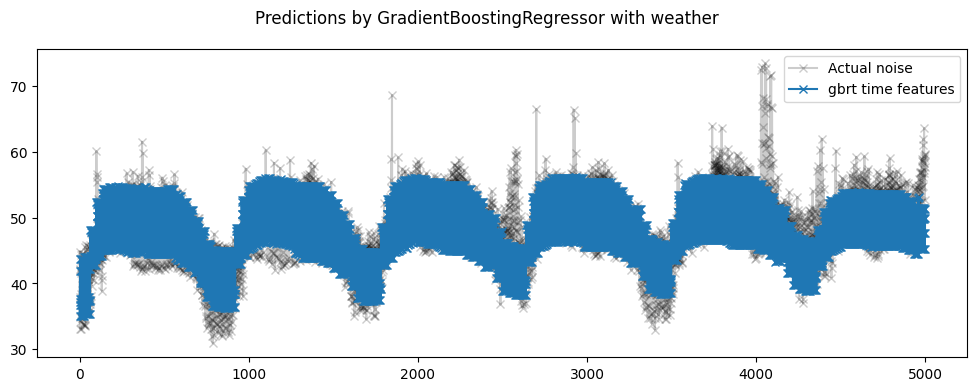

In [146]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_predictions = gbrt_pipeline.predict(X)

last_hours = slice(-5000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by GradientBoostingRegressor with weather")
ax.plot(
    y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


c:\Users\Arthur\miniconda3\envs\course_mda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


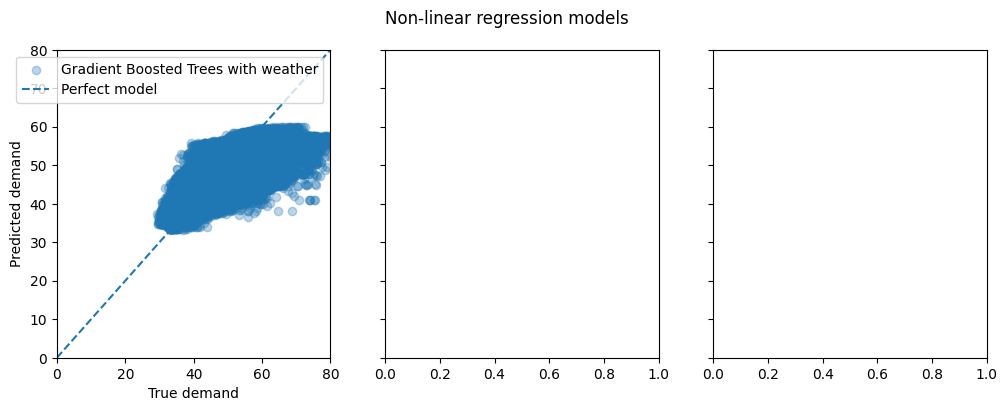

In [147]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()